In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy.spatial
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
%matplotlib inline

In [2]:
print(torch.__version__)

1.2.0


In [65]:
# this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    
    pts = []
    for a, b in zip(np.nonzero(gt)[1], np.nonzero(gt)[0]):
        pts.append([a, b])
    pts = np.array(pts)
    
    # pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    # print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    # print('done.')
    return density

In [66]:
# set the root to the Shanghai dataset you download
root = '/home/zihengh1/CV_Final/CSRNet-pytorch/'

In [67]:
# now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [68]:
print(part_A_train, part_A_test, part_B_train, part_B_test)

/home/zihengh1/CV_Final/CSRNet-pytorch/part_A_final/train_data/images /home/zihengh1/CV_Final/CSRNet-pytorch/part_A_final/test_data/images /home/zihengh1/CV_Final/CSRNet-pytorch/part_B_final/train_data/images /home/zihengh1/CV_Final/CSRNet-pytorch/part_B_final/test_data/images


In [69]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [70]:
len(img_paths)

482

In [71]:
"""
for num, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    if num > 0:
        break
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
        hf['density'] = k
"""

'\nfor num, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):\n    if num > 0:\n        break\n    mat = io.loadmat(img_path.replace(\'.jpg\',\'.mat\').replace(\'images\',\'ground_truth\').replace(\'IMG_\',\'GT_IMG_\'))\n    img= plt.imread(img_path)\n    k = np.zeros((img.shape[0], img.shape[1]))\n    gt = mat["image_info"][0,0][0,0][0]\n    for i in range(len(gt)):\n        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:\n            k[int(gt[i][1]), int(gt[i][0])] = 1\n    k = gaussian_filter_density(k)\n    with h5py.File(img_path.replace(\'.jpg\',\'.h5\').replace(\'images\',\'ground_truth\'), \'w\') as hf:\n        hf[\'density\'] = k\n'

/home/zihengh1/CV_Final/CSRNet-pytorch/part_A_final/train_data/images/IMG_109.jpg


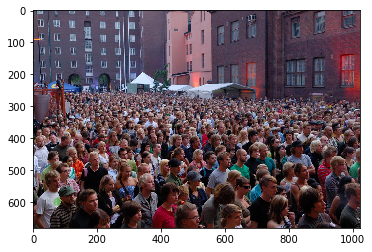

In [72]:
# now see a sample from ShanghaiA
print(img_paths[0])
plt.imshow(Image.open(img_paths[0]))
plt.show()

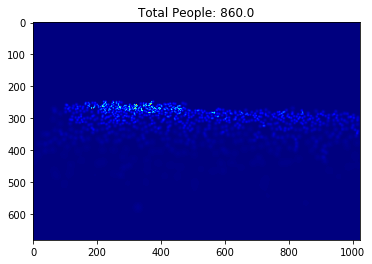

In [73]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.title("Total People: " + str(round(np.sum(groundtruth))))
plt.imshow(groundtruth,cmap=CM.jet)
plt.show()

In [75]:
part_A_people = []
for num in range(len(img_paths)):
    gt_file = h5py.File(img_paths[num].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    part_A_people.append(np.sum(groundtruth))

(array([230., 146.,  47.,  27.,  13.,   5.,   7.,   4.,   2.,   1.]),
 array([  30.141886,  340.1354  ,  650.12897 ,  960.12244 , 1270.116   ,
        1580.1095  , 1890.103   , 2200.0967  , 2510.09    , 2820.0837  ,
        3130.0771  ], dtype=float32),
 <a list of 10 Patch objects>)

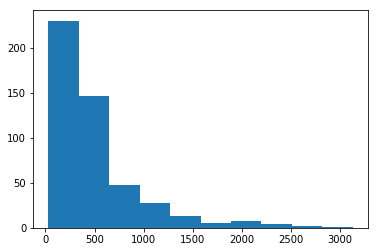

In [80]:
plt.hist(part_A_people)
# plt.show()

In [82]:
# now generate the ShanghaiB's ground truth
path_sets = [part_B_train, part_B_test]

In [83]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [84]:
"""
for num, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    if num > 0:
        break
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
        hf['density'] = k
"""

'\nfor num, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):\n    if num > 0:\n        break\n    mat = io.loadmat(img_path.replace(\'.jpg\',\'.mat\').replace(\'images\',\'ground_truth\').replace(\'IMG_\',\'GT_IMG_\'))\n    img= plt.imread(img_path)\n    k = np.zeros((img.shape[0],img.shape[1]))\n    gt = mat["image_info"][0,0][0,0][0]\n    for i in range(0,len(gt)):\n        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:\n            k[int(gt[i][1]),int(gt[i][0])]=1\n    k = gaussian_filter(k,15)\n    with h5py.File(img_path.replace(\'.jpg\',\'.h5\').replace(\'images\',\'ground_truth\'), \'w\') as hf:\n        hf[\'density\'] = k\n'

/home/zihengh1/CV_Final/CSRNet-pytorch/part_B_final/train_data/images/IMG_294.jpg


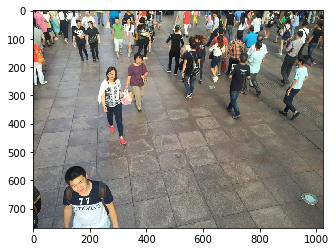

In [85]:
# now see a sample from ShanghaiA
image_num = 10
print(img_paths[image_num])
plt.imshow(Image.open(img_paths[image_num]))
plt.show()

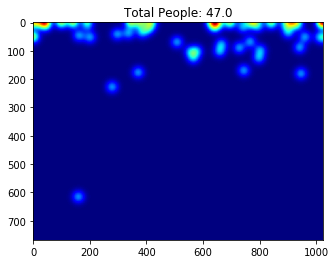

In [86]:
gt_file = h5py.File(img_paths[image_num].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.title("Total People: " + str(round(np.sum(groundtruth))))
plt.imshow(groundtruth,cmap=CM.jet)
plt.show()

In [87]:
part_B_people = []
for num in range(len(img_paths)):
    gt_file = h5py.File(img_paths[num].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    part_B_people.append(np.sum(groundtruth))

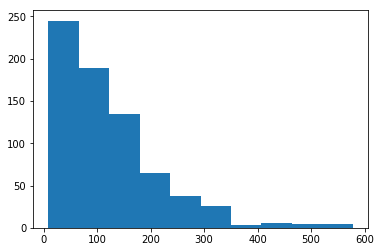

In [89]:
plt.hist(part_B_people)
plt.show()

In [90]:
"""
my_path = "/home/zihengh1/CV_Final/CSRNet-pytorch"
with open('part_B_val.json') as f:
    d = json.load(f)
    for i, text in enumerate(d.copy()):
        d[i] = text.replace("leeyh/Downloads/Shanghai/", "zihengh1/CV_Final/CSRNet-pytorch/")

with open('part_B_val.json', 'w') as outfile:
    json.dump(d, outfile)
"""

'\nmy_path = "/home/zihengh1/CV_Final/CSRNet-pytorch"\nwith open(\'part_B_val.json\') as f:\n    d = json.load(f)\n    for i, text in enumerate(d.copy()):\n        d[i] = text.replace("leeyh/Downloads/Shanghai/", "zihengh1/CV_Final/CSRNet-pytorch/")\n\nwith open(\'part_B_val.json\', \'w\') as outfile:\n    json.dump(d, outfile)\n'